<a href="https://colab.research.google.com/github/Dhanasree-Rajamani/Deep_Learning_Assignments/blob/main/Assignment_7/DL_convolution_layers_depth_wise_pooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import Requirements

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [ ]:
import tensorflow as tf
import sys

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

###Convolution Layers

**Implementing Convolutional Layers With Keras**

In [ ]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [ ]:
images.shape

TensorShape([2, 70, 120, 3])

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

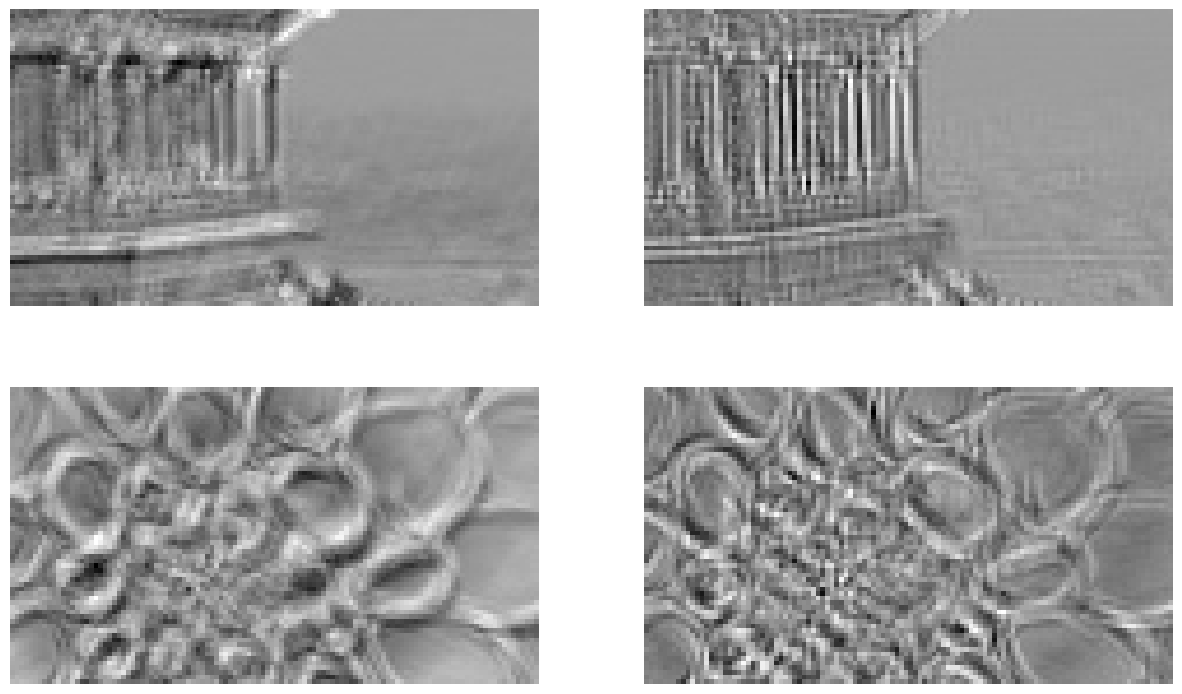

In [ ]:
plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [ ]:
# extra code – shows that the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [ ]:
# extra code – this utility function can be useful to compute the size of the
#              feature maps output by a convolutional layer. It also returns
#              the number of ignored rows or columns if padding="valid", or the
#              number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

In [ ]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [ ]:
biases.shape

(32,)

In [ ]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

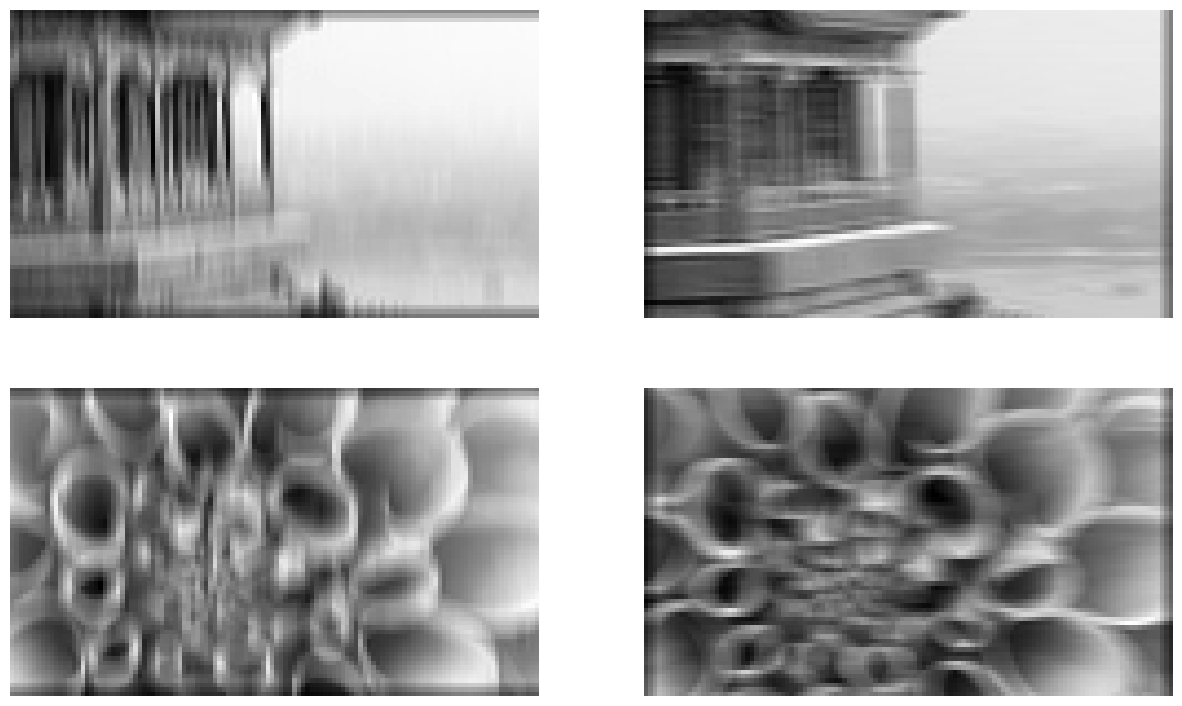

In [ ]:
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

###Pooling Layers

###Implementing Pooling Layers with Keras

**Max Pooling**

In [ ]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [ ]:
output = max_pool(images)

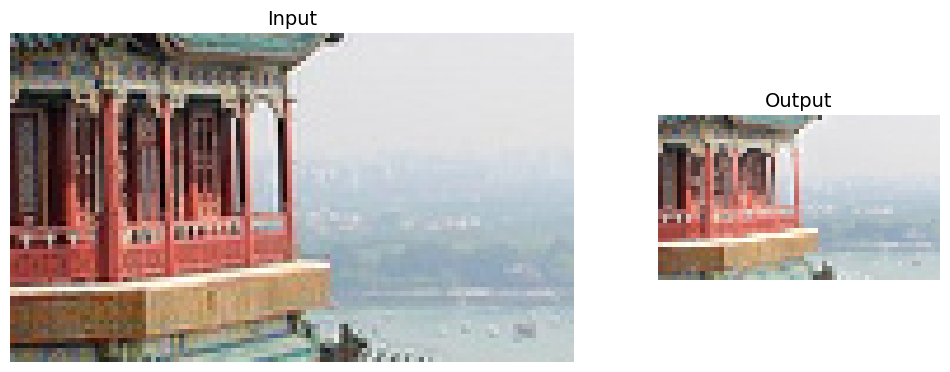

In [ ]:
# extra code – this cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

**Depth Wise Pooling**

In [ ]:
# extra code – shows how to use the max_pool() op; only works on the CPU
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [ ]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [ ]:
# extra code – shows that this custom layer gives the same result as max_pool()
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

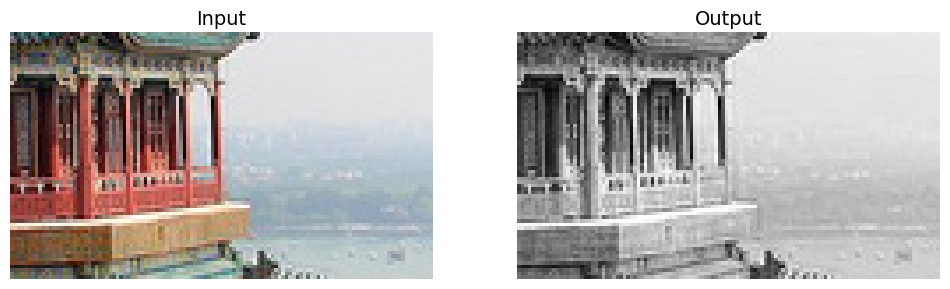

In [ ]:
# extra code – computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

**Global Average Pooling**

In [ ]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

In [ ]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [ ]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.2601088 , 0.10848834]], dtype=float32)>